In [8]:
import sys
import numpy as np
import pandas as pd 
import tensorflow
import tensorflow.compat.v2 as tf
import matplotlib.pyplot as plt 
%matplotlib inline
tensorflow.compat.v1.logging.set_verbosity(tensorflow.compat.v1.logging.ERROR)
sys.path.append("/home/mindy/Documents/projects/creditCardFraud/SupervisedLearning/scripts/")

In [9]:
from util import *
from NN_util import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# make sure GPU is running 
tf.test.gpu_device_name()
set_gpu_limit(7.5)

### Import the same process data from anomaly detection
* feature scale among columns are relatively close so it won't affect gradient descent as much

In [11]:
train = pd.read_csv("../../AnomalyDetection/processedData/TrainingData_normal.csv")
dev = pd.read_csv("../../AnomalyDetection/processedData/DevData_normal.csv")
test = pd.read_csv("../../AnomalyDetection/processedData/hold_outset_moreFraud.csv")

In [12]:
training,testing = train_test_dfs(train,dev,test,"Class",0.1,1988)

### Set CONSTANTS

In [14]:
batch_size = 256
epochs = 100
sizes = [256,256]  # try a 2 layer NN 
input_size = train.shape[1]

### Custom Metrics:
* TruePostivies
* FalsePostives
* FalseNegatives
* PR AUC (precision recall curve, better for imbalanced dataset) 
* Minority Class Precision
* Minority Class Recall 


In [15]:
METRICS = [
    tfk.metrics.TruePositives(name='tp'),
    tfk.metrics.FalsePositives(name='fp'),
    tfk.metrics.FalseNegatives(name='fn'),
    tfk.metrics.AUC(curve = "PR", name = "AUC_PR"),
    tfk.metrics.Precision(class_id = 0, name = "Precsion"),
    tfk.metrics.Recall(class_id = 0, name = "Recall")
]

### Convert to tensorflow dataset

In [18]:
train_set, dev_set = make_tensor_dataset(training,"Class",batch_size,0.2,10090)

### Define earlystop and create model

In [19]:
earlystop = tfk.callbacks.EarlyStopping(monitor="val_AUC_PR",mode="max",patience=20,verbose=1,restore_best_weights=True)

In [20]:
classifier = make_model(sizes,input_size,METRICS)

In [21]:
classifier.summary()

Model: "NN_binary_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256)               73728     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 73,985
Trainable params: 73,985
Non-trainable params: 0
_________________________________________________________________


### tune model 

In [22]:
history = classifier.fit(train_set, epochs=epochs,shuffle=True,
                         verbose = 1, validation_data=dev_set,
                         callbacks=[earlystop])

Epoch 1/100
802/802 [==============================] - 4s 5ms/step - loss: 0.0679 - tp: 105.0000 - fp: 2070.0000 - fn: 263.0000 - AUC_PR: 0.1684 - Precsion: 0.0483 - Recall: 0.2853 - val_loss: 0.0366 - val_tp: 41.0000 - val_fp: 9.0000 - val_fn: 34.0000 - val_AUC_PR: 0.5996 - val_Precsion: 0.8200 - val_Recall: 0.5467
Epoch 2/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0337 - tp: 221.0000 - fp: 36.0000 - fn: 147.0000 - AUC_PR: 0.6413 - Precsion: 0.8599 - Recall: 0.6005 - val_loss: 0.0296 - val_tp: 52.0000 - val_fp: 7.0000 - val_fn: 23.0000 - val_AUC_PR: 0.7700 - val_Precsion: 0.8814 - val_Recall: 0.6933
Epoch 3/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0279 - tp: 258.0000 - fp: 30.0000 - fn: 110.0000 - AUC_PR: 0.7645 - Precsion: 0.8958 - Recall: 0.7011 - val_loss: 0.0251 - val_tp: 60.0000 - val_fp: 10.0000 - val_fn: 15.0000 - val_AUC_PR: 0.7951 - val_Precsion: 0.8571 - val_Recall: 0.8000
Epoch 4/100
802/802 [============================

Epoch 27/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0052 - tp: 301.0000 - fp: 18.0000 - fn: 67.0000 - AUC_PR: 0.8993 - Precsion: 0.9436 - Recall: 0.8179 - val_loss: 0.0052 - val_tp: 61.0000 - val_fp: 5.0000 - val_fn: 14.0000 - val_AUC_PR: 0.8713 - val_Precsion: 0.9242 - val_Recall: 0.8133
Epoch 28/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0052 - tp: 296.0000 - fp: 22.0000 - fn: 72.0000 - AUC_PR: 0.8929 - Precsion: 0.9308 - Recall: 0.8043 - val_loss: 0.0052 - val_tp: 62.0000 - val_fp: 8.0000 - val_fn: 13.0000 - val_AUC_PR: 0.8658 - val_Precsion: 0.8857 - val_Recall: 0.8267
Epoch 29/100
802/802 [==============================] - 3s 4ms/step - loss: 0.0050 - tp: 301.0000 - fp: 15.0000 - fn: 67.0000 - AUC_PR: 0.9065 - Precsion: 0.9525 - Recall: 0.8179 - val_loss: 0.0054 - val_tp: 62.0000 - val_fp: 13.0000 - val_fn: 13.0000 - val_AUC_PR: 0.8584 - val_Precsion: 0.8267 - val_Recall: 0.8267
Epoch 30/100
802/802 [=============================

### Check out results

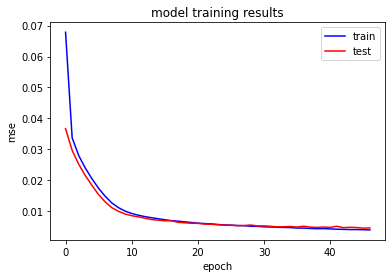

In [23]:
plot_loss(history)

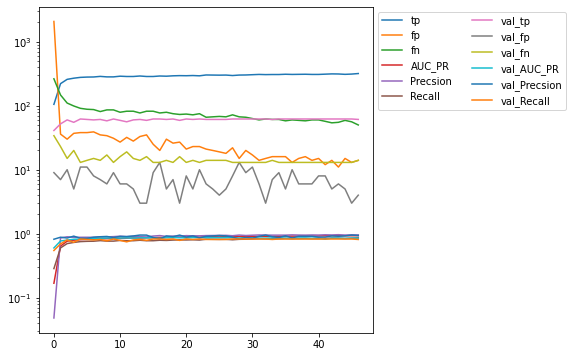

In [24]:
plot_metrics(history)

### check for testing results

In [25]:
test_data, test_label = testing.drop("Class",axis=1).values, testing.Class

In [26]:
test_pred_score = classifier.predict_proba(test_data,batch_size=batch_size).ravel()

In [27]:
test_evaluation = classifier.evaluate(test_data, test_label, batch_size=batch_size)

112/112 [==============================] - 0s 3ms/step - loss: 0.0053 - tp: 40.0000 - fp: 1.0000 - fn: 9.0000 - AUC_PR: 0.8882 - Precsion: 0.9756 - Recall: 0.8163        


In [29]:
for thr in np.arange(0.4,0.61,0.02):
    print(thr)
    output = model_results(test_label,test_pred_score,threshold=thr,ifprint=True)

0.4
[[28430     2]
 [    9    40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.95      0.82      0.88        49

    accuracy                           1.00     28481
   macro avg       0.98      0.91      0.94     28481
weighted avg       1.00      1.00      1.00     28481

0.42000000000000004
[[28430     2]
 [    9    40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.95      0.82      0.88        49

    accuracy                           1.00     28481
   macro avg       0.98      0.91      0.94     28481
weighted avg       1.00      1.00      1.00     28481

0.44000000000000006
[[28430     2]
 [    9    40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.95      0.82      0.88        49

    accuracy                           1.00  

### With a threshold of [0.5,0.52] we are able to reach a f1 score for class 1 of 0.89

In [30]:
output = model_results(test_label,test_pred_score,threshold=0.5,ifprint=True)

[[28431     1]
 [    9    40]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.98      0.82      0.89        49

    accuracy                           1.00     28481
   macro avg       0.99      0.91      0.94     28481
weighted avg       1.00      1.00      1.00     28481

